In [1]:
import numpy as np
import pandas as pd
import os
import cv2

In [2]:
categories=os.listdir(r"/content/drive/MyDrive/Datasets/train")

In [3]:
categories

['Open', 'Closed', 'yawn', 'no_yawn']

In [4]:
# Checking shape of image in an array
import matplotlib.pyplot as plt
a=plt.imread(r"/content/drive/MyDrive/Datasets/train/yawn/108.jpg")
a.shape

(480, 640, 3)

In [5]:
# Creating list of data with features and labels for yawn and no_yawn
def yawn_face(path=r"/content/drive/MyDrive/Datasets/train",face_cas=r"/content/drive/MyDrive/Datasets/data/haarcascade_frontalface_default.xml"):
  yawn=[]
  img_size=145
  labels=["yawn","no_yawn"]
  for label in labels:
    path_link=os.path.join(path,label)
    class_num=labels.index(label)
    print(class_num)
    for image in os.listdir(path_link):
      image_arr=cv2.imread(os.path.join(path_link,image),cv2.IMREAD_COLOR)
      face_cascade=cv2.CascadeClassifier(face_cas)
      faces=face_cascade.detectMultiScale(image_arr,1.3,5)
      for (x,y,w,h) in faces:
        img=cv2.rectangle(image_arr,(x,y),(x+w,y+h),(0,255,0),2)
        roi_color=img[y:y+h,x:x+w]
        resized_array=cv2.resize(roi_color,(img_size,img_size))
        yawn.append([resized_array,class_num])
  return yawn


In [6]:
yawn_noyawn=yawn_face()

0
1


In [7]:
#Creating list of data with features and labels for open and closed eyes
def closed_open(path="/content/drive/MyDrive/Datasets/train",face_cas="/content/drive/MyDrive/Datasets/data/haarcascade_frontalface_default.xml",eye_cas="/content/drive/MyDrive/Datasets/data/haarcascade.xml"):
  labels=["Closed","Open"]
  img_size=145
  eye=[]
  for label in labels:
    path_link=os.path.join(path,label)
    class_num=labels.index(label)
    class_num+=2
    print(class_num)
    for img in os.listdir(path_link):
      try:
        img_arr=cv2.imread(os.path.join(path_link,img),cv2.IMREAD_COLOR)
        resized_arr=cv2.resize(img_arr,(img_size,img_size))
        eye.append([resized_arr,class_num])
      except Exception as e:
        print(e)
  return eye

In [8]:
data_train=closed_open()

2
3


In [9]:
# Combining both data
def append_data():
  yawn=yawn_face()
  eye=closed_open()
  yawn.extend(eye)
  return np.array(yawn,dtype=object)

In [10]:
# Call the function to append data
new_data = append_data()

0
1
2
3


In [11]:
# Seperating label and features
x=[]
y=[]
for feature,label in new_data:
  x.append(feature)
  y.append(label)

In [12]:
# Adjusting all the images to a single size
x=np.array(x)
x=x.reshape(-1,145,145,3)

In [13]:
from sklearn.preprocessing import LabelBinarizer
label_bin=LabelBinarizer()
y=label_bin.fit_transform(y)

In [14]:
y=np.array(y)

In [15]:
# Using train_test_split to divide the data into training and testing set
from sklearn.model_selection import train_test_split
seed=42
test_size=0.30
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=seed,test_size=test_size)

In [16]:
len(x_test)

578

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
# Augmenting Data by normalizing it
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(x_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(x_test), y_test, shuffle=False)

In [19]:
# Creating CNN Layer
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 143, 143, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 71, 71, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 69, 69, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 495,140 (1.89 MB)

 Trainable params: 495,140 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 29s 385ms/step - accuracy: 0.3606 - loss: 1.3140 - val_accuracy: 0.5986 - val_loss: 0.8479
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - accuracy: 0.7515 - loss: 0.6408
Epoch 3/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.7995 - loss: 0.4207 - val_accuracy: 0.8737 - val_loss: 0.3295
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.8435 - loss: 0.3478
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.8548 - loss: 0.3394 - val_accuracy: 0.9221 - val_loss: 0.2155
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.8833 - loss: 0.2654
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.8820 - loss: 0.2754 - val_accuracy: 0.9343 - val_loss: 0.2357
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.8891 - loss: 0.2912
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.9085 - loss: 0.2362 - val_accuracy: 0.9533 - val_loss: 0.1276
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.8997 - loss: 0.2378
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.8925 - loss: 0.2474 - val_accuracy: 0.9533 - val_loss: 0.1289
Epoch 12/50
43/43 ━━━━━

In [23]:
model.save("trained_model.h5")

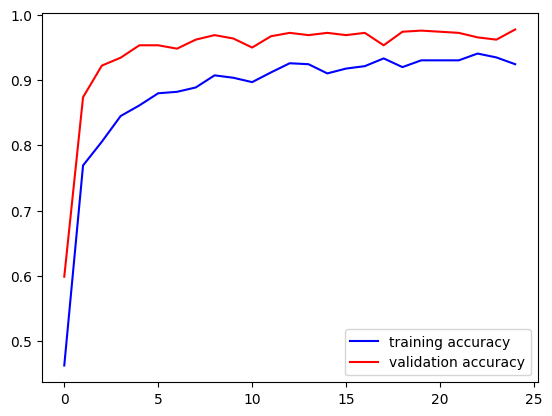

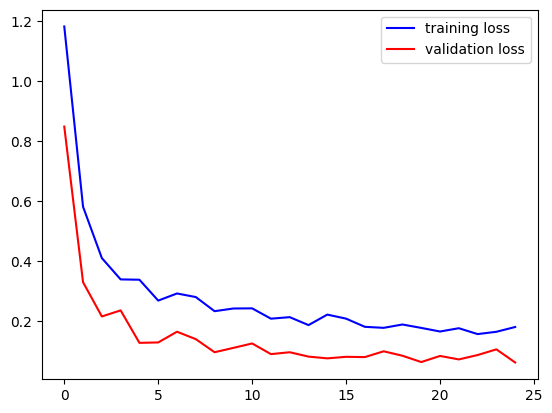

In [25]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object containing training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Use the length of val_accuracy for the number of epochs
epochs = range(len(val_accuracy))

plt.plot(epochs, accuracy[:len(val_accuracy)], "b", label="training accuracy")  # Adjust training accuracy length
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss[:len(val_loss)], "b", label="training loss")  # Adjust training loss length
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()


In [26]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [35]:
predictions = np.argmax(model.predict(x_test), axis=-1)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [36]:
predictions

array([3, 3, 2, 3, 1, 3, 3, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3, 0, 1, 3, 3, 3,
       2, 1, 1, 3, 2, 2, 3, 2, 3, 2, 3, 2, 0, 3, 3, 2, 1, 3, 3, 3, 2, 3,
       2, 2, 3, 3, 2, 3, 3, 1, 2, 1, 3, 3, 2, 2, 2, 0, 3, 3, 1, 2, 2, 3,
       2, 3, 2, 2, 1, 3, 3, 3, 2, 0, 0, 3, 1, 3, 2, 0, 3, 2, 3, 2, 3, 0,
       3, 3, 2, 3, 3, 3, 1, 1, 3, 0, 3, 3, 3, 1, 3, 1, 2, 1, 2, 1, 2, 2,
       1, 1, 2, 1, 0, 3, 3, 3, 2, 2, 3, 3, 3, 1, 1, 2, 3, 3, 2, 0, 3, 3,
       1, 3, 1, 2, 3, 3, 2, 1, 2, 2, 3, 1, 3, 2, 3, 3, 2, 0, 3, 3, 3, 3,
       3, 0, 1, 0, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 3,
       2, 2, 0, 2, 3, 0, 2, 1, 3, 2, 3, 1, 2, 2, 1, 3, 3, 2, 1, 3, 3, 0,
       3, 2, 3, 1, 3, 0, 0, 1, 2, 3, 2, 0, 3, 1, 2, 2, 3, 2, 1, 3, 1, 1,
       1, 0, 2, 3, 3, 3, 3, 0, 1, 2, 0, 1, 3, 3, 1, 3, 3, 1, 3, 3, 0, 1,
       0, 0, 3, 3, 2, 3, 2, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 0, 3, 3, 2, 2,
       3, 2, 2, 0, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 2,
       2, 3, 2, 3, 2, 3, 3, 0, 2, 2, 1, 3, 2, 3, 3,

In [37]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), predictions, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       1.00      0.81      0.89        63
     no_yawn       0.80      0.97      0.88        74
      Closed       0.96      0.86      0.91       215
        Open       0.88      0.95      0.91       226

    accuracy                           0.90       578
   macro avg       0.91      0.90      0.90       578
weighted avg       0.91      0.90      0.91       578

